# load data
注意brk資料少

In [51]:
import pandas as pd

In [52]:
brk = pd.read_csv("./data/brk/2022_BrkNetAmt.csv")
cn = pd.read_csv("./data/concentration/2020_20230814.csv")
ii3 = pd.read_csv("./data/ii3/2020_20230814.csv")
q = pd.read_csv("./data/quote/2020_20230814.csv")

c:\Users\user\Anaconda3\envs\sim_search\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [53]:
merged_df = pd.merge(brk, cn, on=['日期', '股號']).merge(ii3, on=['日期', '股號']).merge(q, on=['日期', '股號']).drop(columns=['成交量_y']) 

In [54]:
merged_df

,日期,股號,分點,買賣超金額,主力買賣超,散戶買賣超,5日籌碼集中度,外資買賣超,投信買賣超,淨成交量,成交量_x,收盤價,漲跌幅(%),成交值(百萬)
0,2022-03-25,3005,9268,107932445,-3795,7656,-9.78,2000,0,10631,11265,51.00,-3.79,581.23
1,2022-01-11,3006,5857,56375750,-2014,3655,-7.23,379,0,5820,8024,145.00,-4.61,1179.53
2,2022-01-13,3006,9672,74145148,-1618,3372,-8.35,-1938,0,4843,10313,144.50,-2.69,1513.13
3,2022-02-08,3006,9307,51427000,364,-889,3.08,60,0,2501,4408,146.00,2.10,643.28
4,2022-02-16,3006,585c,62976225,3052,-4204,8.43,1084,2,10864,19143,155.50,9.89,2919.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1030,2022-02-24,6576,9268,67465715,199,334,4.34,-154,0,2169,2169,119.00,-5.56,260.48
1031,2022-03-04,6576,9268,91706980,-56,131,-0.69,-76,0,1650,1650,125.00,-1.96,206.30
1032,2022-03-25,6576,9227,280258000,629,735,6.67,-861,0,8732,8732,122.00,-5.06,1172.18
1033,2022-03-25,6576,5856,135418000,629,735,6.67,-861,0,8732,8732,122.00,-5.06,1172.18


# 1. CN

## 1.1 preprocess

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

In [80]:
df_6576 = cn[cn['股號']==1605].sort_values(by='日期')
fig = plt.figure(figsize=(20,6))
df_6576
# plt.plot([i for i in range(len(df_6576['日期']))], df_6576['主力買賣超'])

,日期,股號,主力買賣超,散戶買賣超,5日籌碼集中度
602530,2020-01-02,1605,-1987,2741,-2.68
602531,2020-01-03,1605,-1910,4041,-6.10
602532,2020-01-06,1605,293,1050,-5.88
602533,2020-01-07,1605,-541,3552,-3.66
602534,2020-01-08,1605,562,857,-3.44
...,...,...,...,...,...
602868,2023-08-08,1605,5041,-2262,-13.50
602869,2023-08-09,1605,-7254,6778,-15.03
602870,2023-08-10,1605,-9433,5297,-18.19
602871,2023-08-11,1605,-186,2798,-5.19


<Figure size 1440x432 with 0 Axes>

## 1.2 ISOLATION FOREST

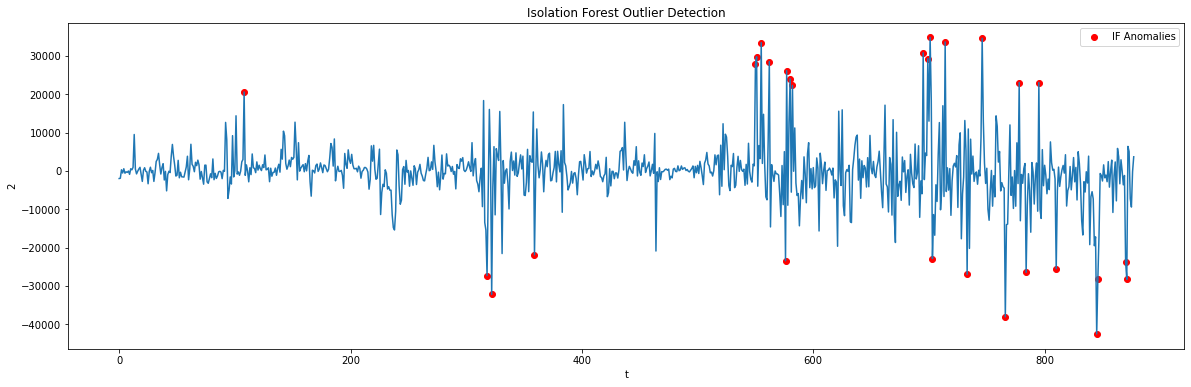

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# Generate some example data (replace this with your dataset)
data = df_6576['主力買賣超'].to_numpy().reshape(-1,1 )
# Fit the Isolation Forest model
clf = IsolationForest(contamination=0.01)  # Adjust contamination based on your data
clf.fit(data[:400])

# Predict outliers (1 for inliers, -1 for outliers)
predictions_iso = clf.predict(data)

# Plot the results
plt.figure(figsize=(20, 6))

# Plot inliers
plt.scatter(np.where(predictions_iso == -1), data[predictions_iso == -1], label='IF Anomalies', color='red')
plt.plot([i for i in range(len(df_6576['日期']))], df_6576['主力買賣超'])

plt.title('Isolation Forest Outlier Detection')
plt.xlabel('t')
plt.ylabel('2')
plt.legend()
plt.show()

## 1.3 ONE CLASS SVM

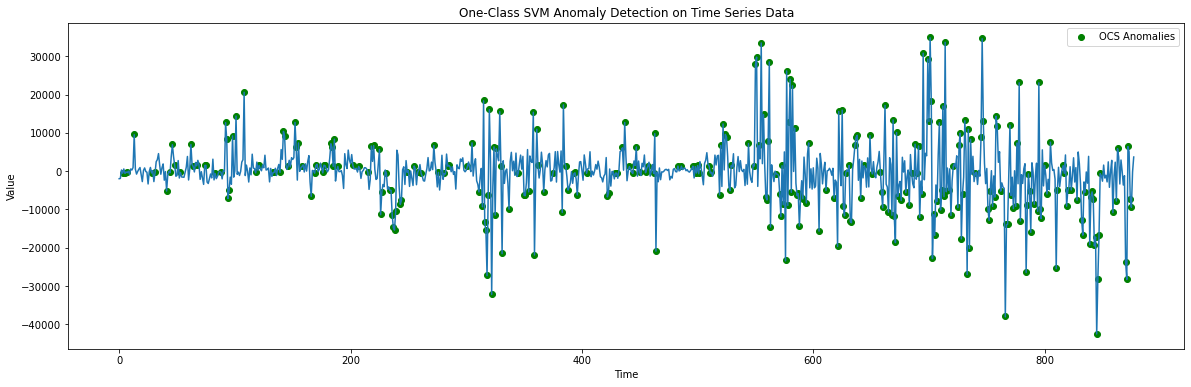

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM

data = df_6576['主力買賣超'].to_numpy().reshape(-1,1 )
# Fit the One-Class SVM model
model = OneClassSVM(nu=0.2, kernel="rbf")  # Adjust nu based on your data
# model.fit(data)
model.fit(data[:400])
# model.fit(data[:200])

# Predict outliers (1 for inliers, -1 for outliers)
predictions_ocs = model.predict(data)

# Plot the time series data with anomalies highlighted
plt.figure(figsize=(20, 6))

# Plot the time series
plt.plot([i for i in range(len(df_6576['日期']))], df_6576['主力買賣超'])

# Highlight anomalies in red
plt.scatter(np.where(predictions_ocs == -1), data[predictions_ocs == -1]+100, label='OCS Anomalies', color='green')

plt.title('One-Class SVM Anomaly Detection on Time Series Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

## 1.4 encoder-decoder

Epoch [10/100], Loss: 1.1477
Epoch [20/100], Loss: 1.0644
Epoch [30/100], Loss: 0.9619
Epoch [40/100], Loss: 0.8570
Epoch [50/100], Loss: 0.7783
Epoch [60/100], Loss: 0.7324
Epoch [70/100], Loss: 0.7104
Epoch [80/100], Loss: 0.7007
Epoch [90/100], Loss: 0.6965
Epoch [100/100], Loss: 0.6944


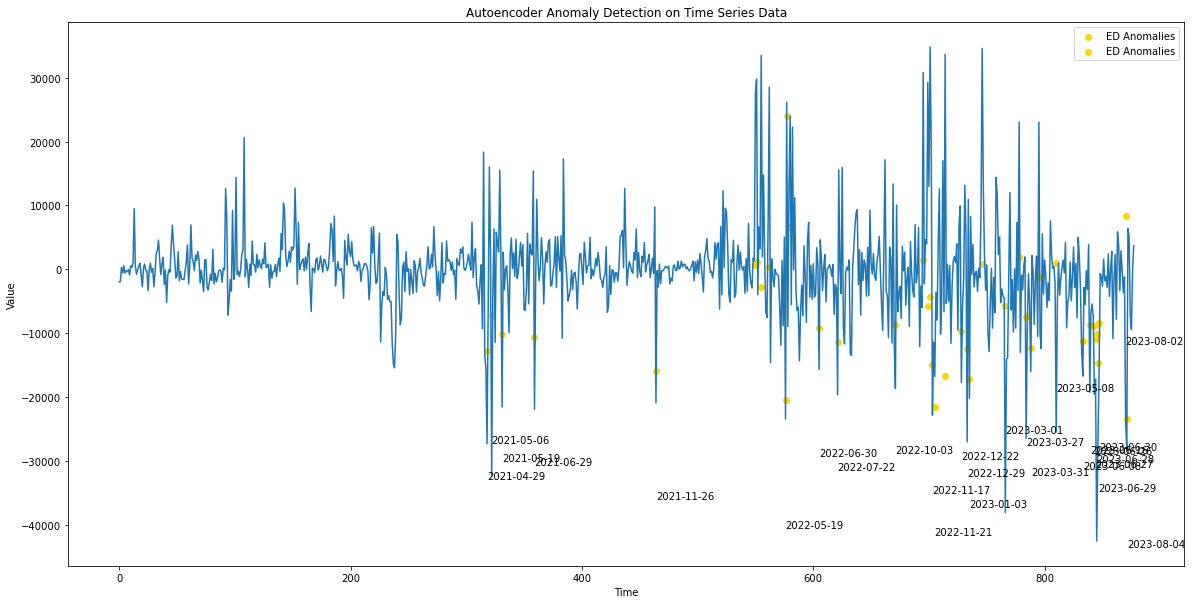

In [93]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# data_test = data.copy()
# Generate example time series data (replace this with your dataset)
# data_or = data.copy()
data = df_6576['主力買賣超'].to_numpy().reshape(-1,1 )
# Normalize the data
data = (data - data.mean()) / data.std()
# data_test = (data_test - data_test.mean()) / data_test.std()

# Convert to PyTorch tensor
data = torch.FloatTensor(data).view(-1, 1)
data_train = data.clone()[:]

# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_size, encoding_size, compressrate1):
        super(Autoencoder, self).__init__()
        self.input = nn.Sequential(nn.Linear(input_size, encoding_size), nn.ReLU())

        self.hidden1 = nn.Sequential(nn.Linear(encoding_size, round(encoding_size*compressrate1)), nn.ReLU())
        self.hidden2 = nn.Sequential(nn.Linear(round(encoding_size*compressrate1), encoding_size), nn.ReLU())

        self.decoder = nn.Sequential(nn.Linear(encoding_size, input_size), nn.Sigmoid())

    def forward(self, x):
        x = self.input(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.decoder(x)
        return x

# Set hyperparameters
input_size = 1  # 1D time series
encoding_size = 50  # Adjust based on your data
compressrate1 = 0.5
num_epochs = 100
learning_rate = 0.001

ap = 97

# Initialize the autoencoder
model = Autoencoder(input_size, encoding_size, compressrate1)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training the autoencoder
for epoch in range(num_epochs):
    # print(data_train)
    outputs = model(data_train)
    loss = criterion(outputs, data_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Reconstruction error for each data point
reconstruction_errors = (model(data) - data).detach().numpy()
# print(reconstruction_errors.shape)
# Plot the time series and highlight anomalies

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

# plt.plot(data, label='Time Series')
plt.plot([i for i in range(len(df_6576['日期']))], df_6576['主力買賣超'])
plt.scatter(np.where(reconstruction_errors > np.percentile(reconstruction_errors, ap))[0], 
            data_or[reconstruction_errors > np.percentile(reconstruction_errors, ap)]-10000,
            label='ED Anomalies', color='gold')

plt.scatter(np.where(reconstruction_errors < -1*np.percentile(reconstruction_errors, ap))[0], 
            data_or[reconstruction_errors < -1*np.percentile(reconstruction_errors, ap)]+1000,
            label='ED Anomalies', color='gold')

for i, val in enumerate(np.where(reconstruction_errors > np.percentile(reconstruction_errors, ap))[0]):
    ax.annotate(df_6576['日期'].reset_index(drop=True)[val], (val, 
                                   data_or[val]-30000))

plt.title('Autoencoder Anomaly Detection on Time Series Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
print()

## 1.5 outlier Summary

1. 訓練資料：每個演算法只取前400筆作為訓練資料
2. 改進方向：演算法調整參數


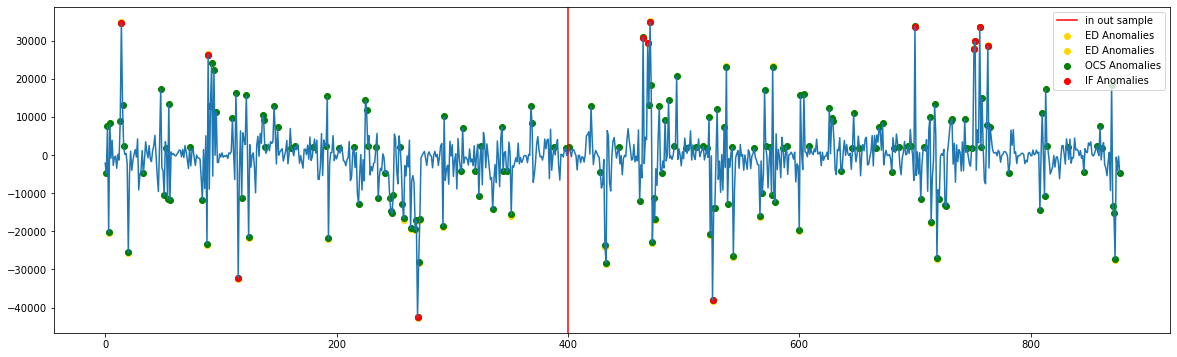

In [ ]:
plt.figure(figsize=(20, 6))
# plt.plot(data, label='Time Series')
plt.plot([i for i in range(len(df_6576['日期']))], df_6576['主力買賣超'])
plt.axvline(x=400, color='red', label='in out sample')


plt.scatter(np.where(reconstruction_errors > np.percentile(reconstruction_errors, ap))[0], 
            data_or[reconstruction_errors > np.percentile(reconstruction_errors, ap)]-200,
            label='ED Anomalies', color='gold')

plt.scatter(np.where(reconstruction_errors < -1*np.percentile(reconstruction_errors, ap))[0], 
            data_or[reconstruction_errors < -1*np.percentile(reconstruction_errors, ap)]+200,
            label='ED Anomalies', color='gold')

plt.scatter(np.where(predictions_ocs == -1), data_or[predictions_ocs == -1]+100, label='OCS Anomalies', color='green')
plt.scatter(np.where(predictions_iso == -1), data_or[predictions_iso == -1], label='IF Anomalies', color='red')

plt.legend()
plt.show()

## 2 Trend stat

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
data = df_6576['主力買賣超'].to_numpy().reshape(-1,1 )

### mono trend test
to test wheather there is trend in window
the result is devided into three types
- increase
- decrease 
- not trend 

In [ ]:
import pymannkendall as mk
from numpy.lib.stride_tricks import sliding_window_view
from tqdm import tqdm

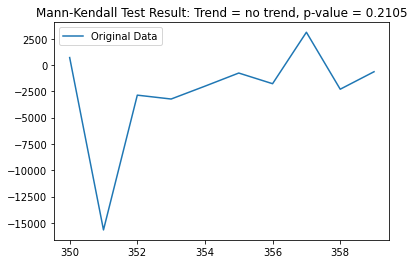

Mann-Kendall Test Result:
Trend = no trend
p-value = 0.2105


In [ ]:
# visualizing
trend, h, p, z, Tau, s, var_s, slope, intercept = mk.original_test(data[350:360])

# Plot the data

plt.plot([i for i in range(350, 360)], data[350:360], label='Original Data')
# Highlight the trend if detected
if h:
    plt.plot([i for i in range(350, 360)], slope * np.array([i for i in range(350, 360)]) + intercept, color='red', label='Trend Line')

plt.title(f'Mann-Kendall Test Result: Trend = {trend}, p-value = {p:.4f}')
plt.legend()
plt.show()

print(f'Mann-Kendall Test Result:\nTrend = {trend}\np-value = {p:.4f}')

In [ ]:
def mk_rolling(ts):
    trend, h, p, z, Tau, s, var_s, slope, intercept = mk.original_test(ts)
    return trend, h

In [ ]:
window_number = 10
data_v = sliding_window_view(data.reshape(-1), window_number)

In [ ]:
res = []
for i in tqdm(range(data_v.shape[0])):
    a, _ = mk_rolling(data_v[i])
    res.append(a)
res = np.array(res)

100%|██████████| 869/869 [00:02<00:00, 404.54it/s]


In [ ]:
np.where(res=='increasing')

(array([  7,  19,  29, 102, 127, 128, 138, 168, 218, 219, 267, 268, 269,
        270, 351, 358, 359, 360, 392, 408, 409, 410, 411, 412, 445, 462,
        463, 473, 480, 497, 619, 621, 659, 660, 661, 687, 688, 701, 704,
        722, 723, 843], dtype=int64),)

In [ ]:
data_v[614:652:10]

array([[  865,  4153,   279,   408,   805, -2814,   700, -1388,  -392,
         -341],
       [  743, -1144, 12303,   313,  9577,  8830,  3785, -3860, -5139,
         1463],
       [ 1125,  4537, -4365, -3743,   941,  3800,  -119,  2724,   325,
         -121],
       [  465, -3758,  1706, 10945,  1432, -1803,   270,  4942,  1819,
        -5443]], dtype=int64)

###